## 1. 프로젝트 : Data Labeling

**프로젝트 요약**
1. Data Labeling
2. Feature Engineering
3. Model Training

**전반적으로 Logistic Regression이 가장 성능이 좋게 나왔고, 일부 중요도가 낮은 피처를 제거했을 때 미약하지만 성능이 더 향상됐다.  
=> 데이터를 더 자세히 알고, 전처리를 진행하면 의미있는 결과가 나올 것 같다.**  
  
  
[노드 진행: 랜덤 포레스트] 
1. 데이터를 1000개 (기본) RandomForest: 0.7731
2. 데이터를 2000개로 증가시키고 교차검증 n_splits을 5로 설정했을 때의 RandomForest: 0.7926
--------------------------------------------------------------------------------
[다른 모델 기본값으로 설정했을 때]
1. LightGBM: 0.768
2. XGBoost: 0.7146
3. Logistic Regression: 0.8881
--------------------------------------------------------------------------------
[모델의 하이퍼 파라미터 추가]
1. LightGBM: 0.7627
2. XGBoost: 0.7449
3. Logistic Regression: 0.8881
---------------------------------------------------------------------------------
* 데이터 3000개로 변경했을 때는 차이가 없었다.
---------------------------------------------------------------------------------
[피처 4개 제거해보기]
LightGBM으로 피처의 중요도를 확인했을 때 순위가 10이상인 피처 4개 제거해보기  
drop_features = ['vol_change_5', 'ret_5', 'vol_change_10', 'vol_change_20']

1. RandomForest (Bagging): 0.8138  
2. LightGBM: 0.7349  
3. XGBoost: 0.7214  
4. **Logistic Regression: 0.8856**  
5. LightGBM_tuning: 0.7679  
6. XGBoost_tuning: 0.7452  
7. **Logistic Regression_tuning:0.8856**    

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

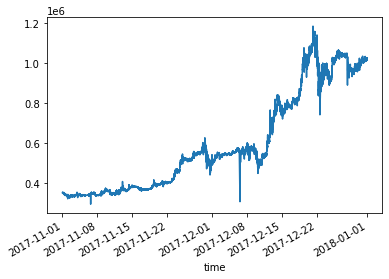

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

### ① Price Change Direction 적용하기
현재 가격과 특정 영업일 이전의 가격의 차이로 Labeling 하는 방식

In [3]:
# window 지정
window = 10 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기
# 1. 현재 종가에서 10일 전 종가를 뺀다 → 10일 동안 가격이 얼마나 변했는지 계산
# 2. np.sign(): 가격 변화의 방향만 추출 → 상승(+1), 보합(0), 하락(-1)
# 3. +1을 더하면: 하락(0), 보합(1), 상승(2)
# 4. 다시 np.sign() 적용:
#    - 0 (하락) → np.sign(0) = 0
#    - 1 (보합) → np.sign(1) = 1
#    - 2 (상승) → np.sign(2) = 1
# → 최종적으로 하락은 0, 보합/상승은 1로 구분
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # 데이터 활용을 위해 pd.Series를 사용 & modify_data와 동일한 인덱스 유지

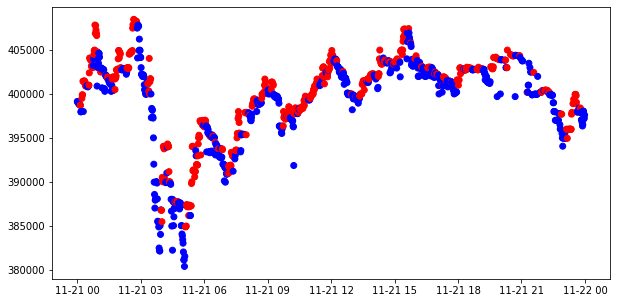

In [4]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']       # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기. 시그널이 1이면 'red', 0이면 'blue'
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue') # np.where 사용

# 시각화하기: 종가를 색상에 따라 점으로 표시
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### ② Using Moving Average 적용하기
 현재의 주가가 특정 이동평균선 위에 있는지, 아래에 있는지 여부로 Labeling을 하는 방식

In [5]:
# momentum_signal
# 종가에서 이동평균(rolling mean)을 뺀다 → 현재가가 평균보다 높은지/낮은지 판단
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) # modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # pd.Series로 변환

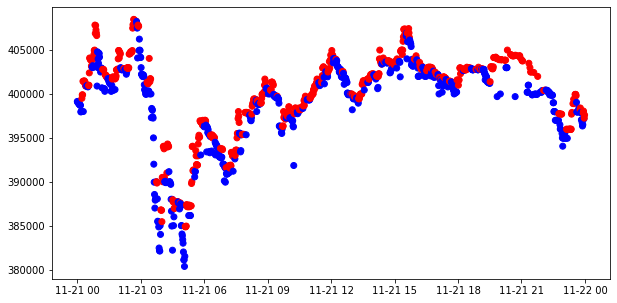

In [6]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### ③ Local Min-Max 적용하기
국지적인 최소 / 최대값을 계속 갱신하여, 최소-최대 구간을 이어나가며 Labeling하는 방식

In [7]:
def get_local_min_max(close, wait=3):  # wait: 일정 횟수만큼 지역 최저/최고가 갱신되지 않으면 다음 국지적 반전이 발생한 것으로 판단
    # 초기 최소값 및 최대값 설정(시계열 첫 번째 값으로 시작)
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    
    # 최소/최대 감지 후 기다릴 카운터 초기화
    n_cnt_min, n_cnt_max = 0, 0
    
    # 결과 저장용 리스트
    mins, maxes = [], []           # 지역 최소값/최대값 저장
    min_idxes, max_idxes = [], []  # 해당 최소값/최대값이 발생한 시점 저장
    
    # 새 최소값/최대값 발견 여부를 추적하는 플래그
    b_min_update, b_max_update = False, False
    
    # 시계열 데이터 루프(두번째 값부터 시작)
    for idx, val in zip(close.index[1:], close.values[1:]):
        
        # 현재 값이 이전 최소값보다 작으면 -> 새로운 지역 최소값 갱신
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
            
        # 현재 값이 이전 최대값보다 크면 -> 새로운 지역 최대값 갱신
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
            
        # 최대값 갱신이 없으면 -> 최소값 관련 카운터 증가
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            # 일정 기간 이상 최소값 갱신없이 지나면 최대값 초기화
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
                
        # 최소값 갱신이 없으면 -> 최대값 관련 카운터 증가
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            # 일정 기간 이상 최대값 갱신없이 지나면 최소값 초기화
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
                
    # 결과를 두 개의 DataFrame으로 반환(지역 최소값, 지역 최대값)
    return (
        pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min':mins}),
        pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max':maxes})
    )

In [8]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

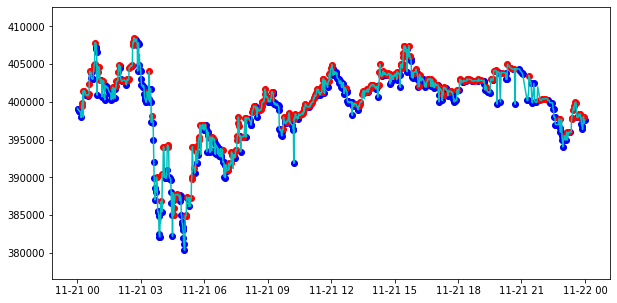

In [9]:
# 시각화
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue')  # 지역 최솟값(mins)을 파란색 점으로 표시

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red') # 지역 최댓값(maxes)을 빨간색 점으로 표시

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

### ④ Trend Scanning 적용하기

In [10]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [16]:
look_forward_window = 60  # 미래로 60개의 데이터를 바라보며 분석할 윈도우 크기 설정
min_sample_length = 5     # 최소 샘플 길이: 회귀분석을 적용하기 위해 필요한 최소 데이터 수
step = 1                  # 한 번에 이동할 인덱스 수 (슬라이딩 윈도우의 간격)
t1_array = []             # 회귀 분석에 사용된 각 윈도우의 종료 시점 인덱스를 저장할 리스트
t_values_array = []       # 각 윈도우 구간에서 계산된 t-value 를 저장할 리스트

In [18]:
# Q. 코드를 작성해주세요

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [14:50<00:00, 37.48it/s]


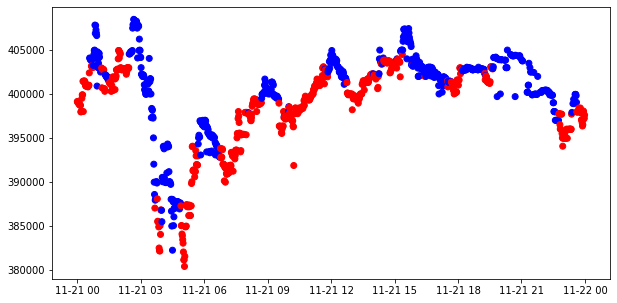

In [19]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

## 2. 프로젝트 : Feature Engineering

### ① 환경구성 및 데이터 불러오기

In [20]:
# !pip install ta==0.9.0
# !pip install shap

In [21]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [22]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

### ② Technical Index 적용하기
1) 기술적 지표

아래 여러 지표들을 기존의 데이터셋에 추가하는 과정  
  
2) 수익률 / 변동성 지표

여러 지표들이 추가된 데이터셋에서 활용하고자 하는 시점에 수익률과 변동성 적용
수익률 / 변동성까지 적용된 데이터셋을 표준화(standardization)하고 fit_transform하여 RandomForest에 적용합니다.   
아래 Feature Selection을 하기 위한 선행과정입니다.

In [23]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [24]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [25]:
# 특징(feature) 데이터와 라벨(label) 데이터를 결합하고, 결측치가 있는 행 제거
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [26]:
# RandomForest 모델 적용
# class_weight='balanced'는 소수 클래스에 더 많은 가중치를 부여해 학습 성능 향상
rfc = RandomForestClassifier(class_weight='balanced') 

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

### ③ Feature Selection methods 적용하기
#### MDI, Mean Decrease Impurity 

In [27]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.050417,0.002263
volume_fi,0.042850,0.002406
volume_mfi,0.041635,0.002189
volume_sma_em,0.037601,0.001804
volume_vpt,0.025948,0.001575
volatility_atr,0.072632,0.002996
volatility_ui,0.049404,0.002378
trend_macd_diff,0.079221,0.003787
trend_adx,0.050293,0.002537
trend_trix,0.071045,0.003297


#### MDA, Mean Decrease Accuracy

In [28]:
# MDA, Mean Decrease Accuracy
from lightgbm import LGBMClassifier

# svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
lgbm = LGBMClassifier(random_state=42)  # LightGBM 사용
cv = KFold(n_splits=10, shuffle=True, random_state=42) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(lgbm, X_sc, y, cv_gen=cv)

In [29]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

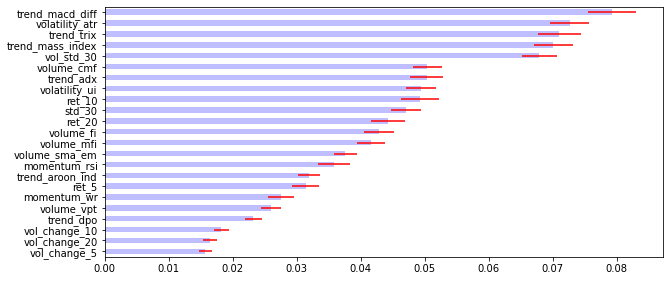

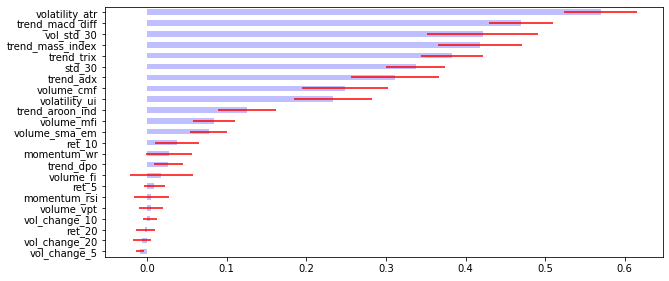

In [30]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

**상위 막대 (Top)**   
→ 모델이 예측에 크게 의존하는 중요 피처  
→ 향후 설명력, 해석력, 피처 엔지니어링 시 최우선 고려 대상  
  
**하위 막대 (Bottom)**  
→ 제거해도 모델 성능에 거의 영향 없는 피처  
→ 불필요하거나 노이즈일 가능성 있음  
  
**에러 바가 큰 피처**  
→ 데이터에 따라 중요도가 흔들림 → 추가 분석 필요

#### RFE CV, Recursive Feature Elimination

In [31]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

In [32]:
# 선택된 피쳐 확인하기

# 피처 선택 결과를 DataFrame으로 정리
# - Optimal_Features: 선택된 피처는 True
# - Ranking: 중요도 순위 (1이 가장 중요, 숫자가 클수록 덜 중요)
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,True,1
volume_fi,True,1
volume_mfi,False,2
volume_sma_em,True,1
volume_vpt,True,1
volatility_atr,True,1
volatility_ui,True,1
trend_macd_diff,True,1
trend_adx,False,7
trend_trix,True,1


In [33]:
# LightGBM으로 확인
lgbm = LGBMClassifier(random_state=42)
rfe_cv = RFECV(estimator=lgbm, cv=cv) # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,True,1
volume_fi,False,2
volume_mfi,True,1
volume_sma_em,True,1
volume_vpt,False,5
volatility_atr,True,1
volatility_ui,True,1
trend_macd_diff,True,1
trend_adx,True,1
trend_trix,True,1


In [34]:
# rfe_df에서 최적의 피처만 추출
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volume_cmf,True,1
volume_mfi,True,1
volume_sma_em,True,1
volatility_atr,True,1
volatility_ui,True,1
trend_macd_diff,True,1
trend_adx,True,1
trend_trix,True,1
trend_mass_index,True,1
std_30,True,1


#### SFS, Sequential Feature Selection

In [35]:
# SFS, Sequential Feature Selection

n = 3
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [36]:
# 선택된 피쳐 확인하기

# 선택된 피처를 불리언 배열 형태로 반환 (선택된 피처: True, 나머지: False)
sfs_rank = sfs_fitted.get_support()

# 불리언 배열을 데이터프레임으로 변환 (각 피처별 선택 여부를 표시)
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})

# 선택된 피처(True)만 필터링하여 그 인덱스(=컬럼명, 즉 피처 이름) 추출
sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff', 'trend_dpo'], dtype='object')

#### SHAP, Shapley Additive explanations

<Figure size 432x288 with 0 Axes>

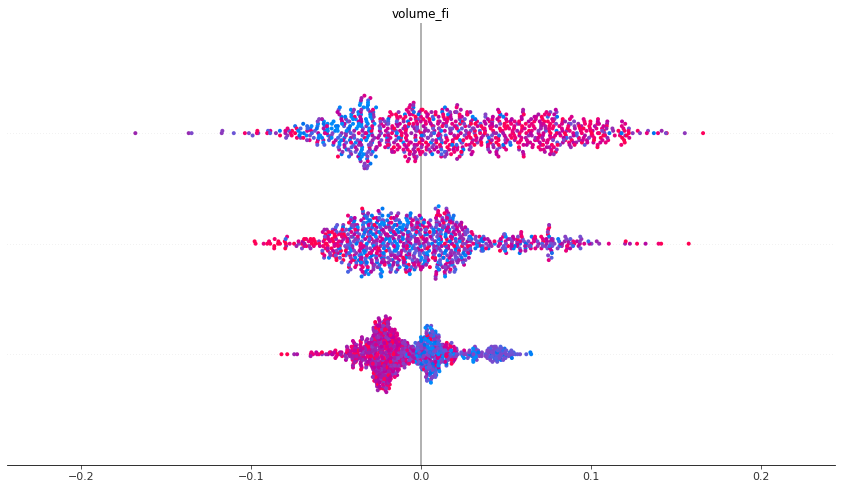

In [37]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

## 3. 프로젝트 : Model Traning

### ① 환경구성 및 데이터 불러오기

In [89]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [90]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:2000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다. - LMS노드에서는 1000으로 비교
train_y = train_y[:2000]

### ② Purged K-fold for Cross-Validation적용하기

In [91]:
# Q. 코드를 작성해주세요

n_cv = 5     # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
             # 데이터를 1000개 더 넣었으므로 조금 더 잘게 나눠서 안정성이 높아지는지 (LMS노드에는 4로 진행해서 비교)
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

### ③ Model 적용하기

In [92]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [93]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [94]:
# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [95]:
# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [96]:
# # fit
# gs_rfc.fit(train_x, train_y)

# # best estimator 
# gs_rfc_best = gs_rfc.best_estimator
# gs_rfc_best.fit(train_x, train_y)

**파라미터 튜닝 결과**  
BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',  
max_depth=10,  
max_features=None,  
min_samples_leaf=10),  
max_features=0.7, n_estimators=5)

In [97]:
# 하이퍼 파라미터 직접 입력
gs_rfc_best = BaggingClassifier(
    base_estimator=RandomForestClassifier(
                class_weight='balanced',
                max_depth=10,
                max_features=None,
                min_samples_leaf=10,
                random_state=42),
    n_estimators=5,
    max_features=0.7,
    random_state=42)

gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=None,
                                                        min_samples_leaf=10,
                                                        random_state=42),
                  max_features=0.7, n_estimators=5, random_state=42)

In [98]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [99]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[84 52]
 [11 44]]
정확도:0.6701570680628273, 정밀도:0.4583333333333333, 재현율:0.8


auc:0.7926470588235294


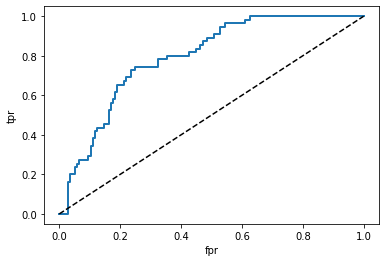

In [100]:
# ROC curve 만들기
# - fpr: False Positive Rate (거짓 양성률)
# - tpr: True Positive Rate (진짜 양성률)
# - thresholds: 결정 임곗값
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])

# AUC (Area Under Curve) 계산 - ROC 곡선 아래 면적
# - 모델이 양성과 음성을 얼마나 잘 구분하는지 나타냄 (1.0에 가까울수록 좋음
auc = roc_auc_score(test_y, prob_y[:,1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### 모델 추가하고 점수와 시각화 비교

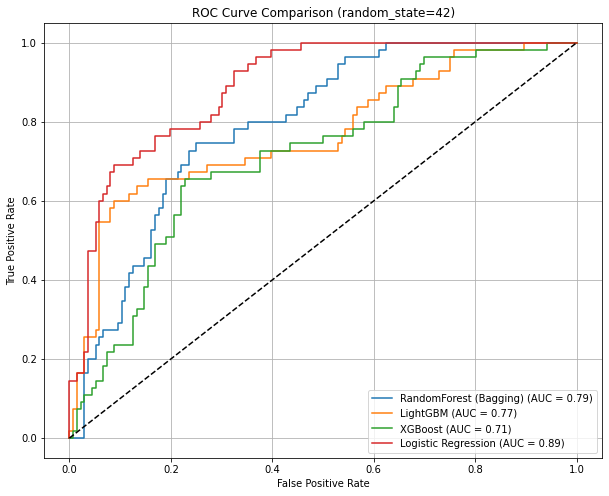


 RandomForest (Bagging)
  Accuracy: 0.6702, Precision: 0.4583, Recall: 0.8, AUC: 0.7926

 LightGBM
  Accuracy: 0.5445, Precision: 0.3621, Recall: 0.7636, AUC: 0.768

 XGBoost
  Accuracy: 0.5497, Precision: 0.3652, Recall: 0.7636, AUC: 0.7146

 Logistic Regression
  Accuracy: 0.7277, Precision: 0.5152, Recall: 0.9273, AUC: 0.8881


In [101]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# 모델 정의(random_state=42로 고정)
gs_rfc_best = BaggingClassifier(
    base_estimator=RandomForestClassifier(
                class_weight='balanced',
                max_depth=10,
                max_features=None,
                min_samples_leaf=10,
                random_state=42),
    n_estimators=5,
    max_features=0.7,
    random_state=42)

# 기본값 파라미터
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(random_state=42)

# 모델 리스트
models = {
    'RandomForest (Bagging)': gs_rfc_best,
    'LightGBM': lgbm,
    'XGBoost': xgb,
    'Logistic Regression': lr
}

# 결과 저장 및 ROC 시각화
results = []
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(train_x, train_y)
    prob_y = model.predict_proba(test_x)
    pred_y = model.predict(test_x)

    fpr, tpr, _ = roc_curve(test_y, prob_y[:,1])
    auc = roc_auc_score(test_y, prob_y[:,1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    cm = confusion_matrix(test_y, pred_y)
    acc = accuracy_score(test_y, pred_y)
    prec = precision_score(test_y, pred_y)
    rec = recall_score(test_y, pred_y)
    
    results.append((name, acc, prec, rec, auc, cm))
    
# ROC 그래프
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (random_state=42)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# 결과 출력
for r in results:
    print(f"\n {r[0]}")
    print(f"  Accuracy: {r[1]:.4}, Precision: {r[2]:.4}, Recall: {r[3]:.4}, AUC: {r[4]:.4}")

### 하이퍼 파라미터 추가

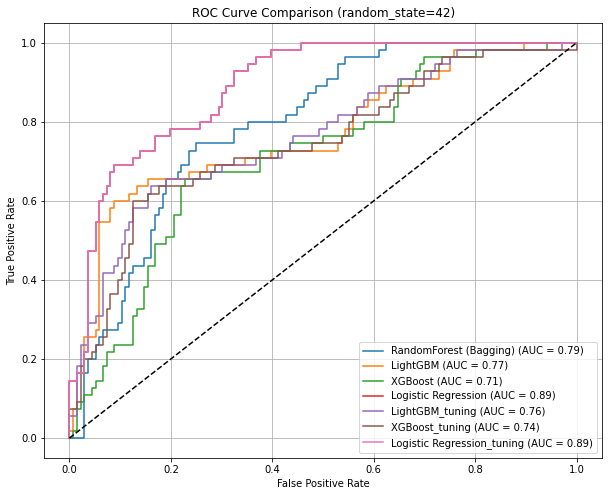


 RandomForest (Bagging)
  Accuracy: 0.6702, Precision: 0.4583, Recall: 0.8, AUC: 0.7926

 LightGBM
  Accuracy: 0.5445, Precision: 0.3621, Recall: 0.7636, AUC: 0.768

 XGBoost
  Accuracy: 0.5497, Precision: 0.3652, Recall: 0.7636, AUC: 0.7146

 Logistic Regression
  Accuracy: 0.7277, Precision: 0.5152, Recall: 0.9273, AUC: 0.8881

 LightGBM_tuning
  Accuracy: 0.5707, Precision: 0.3846, Recall: 0.8182, AUC: 0.7627

 XGBoost_tuning
  Accuracy: 0.5393, Precision: 0.359, Recall: 0.7636, AUC: 0.7449

 Logistic Regression_tuning
  Accuracy: 0.7277, Precision: 0.5152, Recall: 0.9273, AUC: 0.8881


In [102]:
# 모델 정의(random_state=42로 고정)
gs_rfc_best = BaggingClassifier(
    base_estimator=RandomForestClassifier(
                class_weight='balanced',
                max_depth=10,
                max_features=None,
                min_samples_leaf=10,
                random_state=42),
    n_estimators=5,
    max_features=0.7,
    random_state=42)

# 기본값 파라미터
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(random_state=42)

# 하이퍼 파라미터 추가
lgbm_tuning = LGBMClassifier(class_weight='balanced', 
                             n_estimators=500,
                             learning_rate=0.05,
                             max_depth=6,
                             num_leaves=32,
                             random_state=42)
xgb_tuning = XGBClassifier(use_label_encoder=False, 
                    eval_metric='logloss',
                    n_estimators=300,
                    learning_rate=0.1,
                    max_depth=6,
                    colsample_bytree=0.8,       
                    random_state=42)
lr_tuning = LogisticRegression(max_iter=1000,
                        random_state=42)

# 모델 리스트
models = {
    'RandomForest (Bagging)': gs_rfc_best,
    'LightGBM': lgbm,
    'XGBoost': xgb,
    'Logistic Regression': lr,
    'LightGBM_tuning': lgbm_tuning,
    'XGBoost_tuning': xgb_tuning,
    'Logistic Regression_tuning': lr_tuning
}

# 결과 저장 및 ROC 시각화
results = []
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(train_x, train_y)
    prob_y = model.predict_proba(test_x)
    pred_y = model.predict(test_x)

    fpr, tpr, _ = roc_curve(test_y, prob_y[:,1])
    auc = roc_auc_score(test_y, prob_y[:,1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    cm = confusion_matrix(test_y, pred_y)
    acc = accuracy_score(test_y, pred_y)
    prec = precision_score(test_y, pred_y)
    rec = recall_score(test_y, pred_y)
    
    results.append((name, acc, prec, rec, auc, cm))
    
# ROC 그래프
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (random_state=42)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# 결과 출력
for r in results:
    print(f"\n {r[0]}")
    print(f"  Accuracy: {r[1]:.4}, Precision: {r[2]:.4}, Recall: {r[3]:.4}, AUC: {r[4]:.4}")

### 피처 4개 제거해보기
LightGBM 으로 확인했을 때 순위가 10이상인 피처 4개 제거해보기
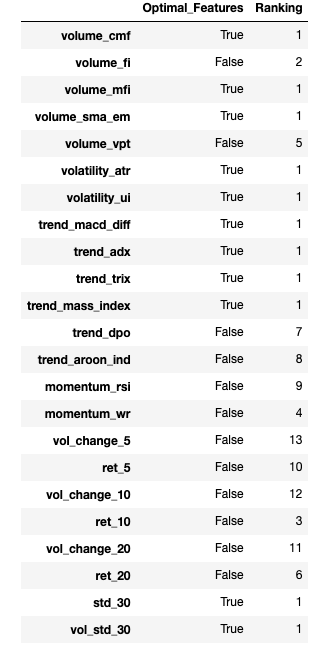

In [104]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

drop_features = ['vol_change_5', 'ret_5', 'vol_change_10', 'vol_change_20']
df_data2 = df_data.drop(columns=drop_features)

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data2) * train_ratio))
n_test = int(np.round(len(df_data2) * test_ratio))

X, y = df_data2.iloc[:, 5:-1], df_data2.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:2000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다. - LMS노드에서는 1000으로 비교
train_y = train_y[:2000]

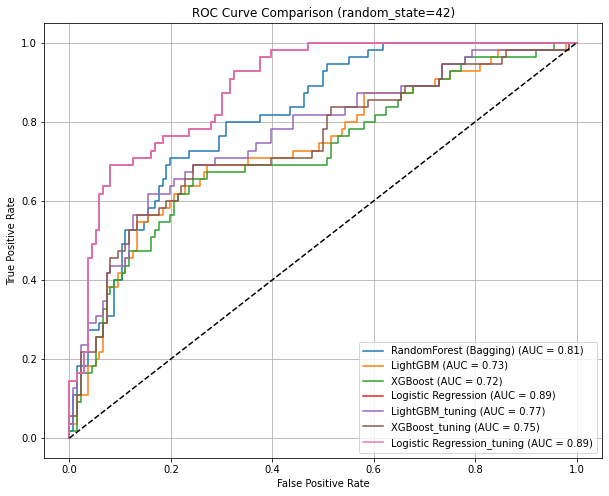


 RandomForest (Bagging)
  Accuracy: 0.6754, Precision: 0.4632, Recall: 0.8, AUC: 0.8138

 LightGBM
  Accuracy: 0.5654, Precision: 0.375, Recall: 0.7636, AUC: 0.7349

 XGBoost
  Accuracy: 0.5497, Precision: 0.3628, Recall: 0.7455, AUC: 0.7214

 Logistic Regression
  Accuracy: 0.7225, Precision: 0.51, Recall: 0.9273, AUC: 0.8856

 LightGBM_tuning
  Accuracy: 0.5759, Precision: 0.3879, Recall: 0.8182, AUC: 0.7679

 XGBoost_tuning
  Accuracy: 0.5812, Precision: 0.3894, Recall: 0.8, AUC: 0.7452

 Logistic Regression_tuning
  Accuracy: 0.7225, Precision: 0.51, Recall: 0.9273, AUC: 0.8856


In [105]:
# 모델 정의(random_state=42로 고정)
gs_rfc_best = BaggingClassifier(
    base_estimator=RandomForestClassifier(
                class_weight='balanced',
                max_depth=10,
                max_features=None,
                min_samples_leaf=10,
                random_state=42),
    n_estimators=5,
    max_features=0.7,
    random_state=42)

# 기본값 파라미터
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr = LogisticRegression(random_state=42)

# 하이퍼 파라미터 추가
lgbm_tuning = LGBMClassifier(class_weight='balanced', 
                             n_estimators=500,
                             learning_rate=0.05,
                             max_depth=6,
                             num_leaves=32,
                             random_state=42)
xgb_tuning = XGBClassifier(use_label_encoder=False, 
                    eval_metric='logloss',
                    n_estimators=300,
                    learning_rate=0.1,
                    max_depth=6,
                    colsample_bytree=0.8,       
                    random_state=42)
lr_tuning = LogisticRegression(max_iter=1000,
                        random_state=42)

# 모델 리스트
models = {
    'RandomForest (Bagging)': gs_rfc_best,
    'LightGBM': lgbm,
    'XGBoost': xgb,
    'Logistic Regression': lr,
    'LightGBM_tuning': lgbm_tuning,
    'XGBoost_tuning': xgb_tuning,
    'Logistic Regression_tuning': lr_tuning
}

# 결과 저장 및 ROC 시각화
results = []
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(train_x, train_y)
    prob_y = model.predict_proba(test_x)
    pred_y = model.predict(test_x)

    fpr, tpr, _ = roc_curve(test_y, prob_y[:,1])
    auc = roc_auc_score(test_y, prob_y[:,1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    cm = confusion_matrix(test_y, pred_y)
    acc = accuracy_score(test_y, pred_y)
    prec = precision_score(test_y, pred_y)
    rec = recall_score(test_y, pred_y)
    
    results.append((name, acc, prec, rec, auc, cm))
    
# ROC 그래프
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison (random_state=42)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# 결과 출력
for r in results:
    print(f"\n {r[0]}")
    print(f"  Accuracy: {r[1]:.4}, Precision: {r[2]:.4}, Recall: {r[3]:.4}, AUC: {r[4]:.4}")